In [1]:
#must be very first statement

import tensorflow as tf
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Num GPUs Available:  0
Please install GPU version of TF


In [18]:
%config IPCompleter.greedy=True

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.datasets import mnist
import PIL


def getDigits(show=False):
    (x_train, t_train), (x_test, t_test) = mnist.load_data()

    #print(x_train.shape)

    if show:
        showImages(x_train, t_train,5)

    return x_train,t_train,x_test, t_test


#### CALLBACKS (https://github.com/davidADSP/GDL_code/blob/master/utils/callbacks.py)
class CustomCallback(Callback):

    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size=(1, self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images',
                                    'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1

#### CALLBACKS (https://github.com/davidADSP/GDL_code/blob/master/utils/callbacks.py)
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''

    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch / step_size))

        return new_lr

    return LearningRateScheduler(schedule)

In [32]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

import numpy as np
import json
import os
import pickle


class VariationalAutoencoder():
    def __init__(self
                 , input_dim
                 , encoder_conv_filters
                 , encoder_conv_kernel_size
                 , encoder_conv_strides
                 , decoder_conv_t_filters
                 , decoder_conv_t_kernel_size
                 , decoder_conv_t_strides
                 , z_dim
                 , use_batch_norm=False
                 , use_dropout=False
                 ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):

        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters=self.encoder_conv_filters[i]
                , kernel_size=self.encoder_conv_kernel_size[i]
                , strides=self.encoder_conv_strides[i]
                , padding='same'
                , name='encoder_conv_' + str(i)
            )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate=0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]
#-----------------------------
        print("shape_bef_flat",shape_before_flattening)
        x = Flatten()(x)
        print("shape_aft_flat",x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])
        print("encoder_output: ",encoder_output)
        self.encoder = Model(encoder_input, encoder_output)

        ### THE DECODER

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        print("dec_input",decoder_input)
        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters=self.decoder_conv_t_filters[i]
                , kernel_size=self.decoder_conv_t_kernel_size[i]
                , strides=self.decoder_conv_t_strides[i]
                , padding='same'
                , name='decoder_conv_t_' + str(i)
            )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate=0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x
        print("dec_inputtii",decoder_input)
        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)
        
        self.model = Model(model_input, model_output)

    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        ### COMPILATION
        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
            return r_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return r_loss + kl_loss

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss])

    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
            ], f)

        self.plot_model(folder)

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches=100, initial_epoch=0, lr_decay=1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint_filepath = os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only=True, verbose=1)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.fit(
            x_train
            , x_train
            , batch_size=batch_size
            , shuffle=True
            , epochs=epochs
            , initial_epoch=initial_epoch
            , callbacks=callbacks_list
        )

    def train_with_generator(self, data_flow, epochs, steps_per_epoch, run_folder, print_every_n_batches=100,
                             initial_epoch=0, lr_decay=1, ):

        custom_callback = utilities.CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = utilities.step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint_filepath = os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only=True, verbose=1)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))

        self.model.fit_generator(
            data_flow
            , shuffle=True
            , epochs=epochs
            , initial_epoch=initial_epoch
            , callbacks=callbacks_list
            , steps_per_epoch=steps_per_epoch
        )

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder, 'viz/model.png'), show_shapes=True,
                   show_layer_names=True)
        plot_model(self.encoder, to_file=os.path.join(run_folder, 'viz/encoder.png'), show_shapes=True,
                   show_layer_names=True)
        plot_model(self.decoder, to_file=os.path.join(run_folder, 'viz/decoder.png'), show_shapes=True,
                   show_layer_names=True)



In [13]:
from keras.datasets import cifar10
cifar10.load_data()



170500096/170498071 [==============================] - 33s 0us/step


((array([[[[ 59,  62,  63],
           [ 43,  46,  45],
           [ 50,  48,  43],
           ...,
           [158, 132, 108],
           [152, 125, 102],
           [148, 124, 103]],
  
          [[ 16,  20,  20],
           [  0,   0,   0],
           [ 18,   8,   0],
           ...,
           [123,  88,  55],
           [119,  83,  50],
           [122,  87,  57]],
  
          [[ 25,  24,  21],
           [ 16,   7,   0],
           [ 49,  27,   8],
           ...,
           [118,  84,  50],
           [120,  84,  50],
           [109,  73,  42]],
  
          ...,
  
          [[208, 170,  96],
           [201, 153,  34],
           [198, 161,  26],
           ...,
           [160, 133,  70],
           [ 56,  31,   7],
           [ 53,  34,  20]],
  
          [[180, 139,  96],
           [173, 123,  42],
           [186, 144,  30],
           ...,
           [184, 148,  94],
           [ 97,  62,  34],
           [ 83,  53,  34]],
  
          [[177, 144, 116],
           [16

In [16]:
my_labels = [6]
all_label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_names = []
for label_index in my_labels:
    label_names.append(all_label_names[label_index])  

print("Defining new Labeling:")
print(dict(zip(range(len(my_labels)),label_names)))

#if my_labels = [5,6,8] then 5 returns 0, 6 returns 1, 8 returns 2, ...
def convert_label(label):
    return dict(zip(my_labels,range(len(my_labels))))[label]

def label_name(num):
    return label_names[num]

# The data, split between train and test sets:
(x_train_all, y_train_all), (x_test_all, y_test_all) = cifar10.load_data()
    
#temp lists
x_train = []
y_train_numerical = []

#filter training data for my_labels
for i in range(len(x_train_all)):
    if y_train_all[i] in my_labels:
        x_train.append(x_train_all[i])
        y_train_numerical.append(convert_label(y_train_all[i][0]))
    else:
        pass

x_train = np.array(x_train)
y_train_numerical = np.array(y_train_numerical)

print("Training Data:\n")
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'samples,', y_train_numerical.shape[0], 'labels')
print("\nClass  |  Counts:")
(unique, counts) = np.unique(y_train_numerical, return_counts=True)
for i, label in enumerate(unique):
    print(label_name(label),"\t", counts[i])


x_test = []
y_test_numerical = []

#filter test data
for i in range(len(x_test_all)):
    if y_test_all[i] in my_labels:
        x_test.append(x_test_all[i])
        y_test_numerical.append(convert_label(y_test_all[i][0]))
    else:
        pass

x_test = np.array(x_test)
y_test_numerical = np.array(y_test_numerical)

print("\n\nTesting Data:\n")
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'samples,', y_test_numerical.shape[0], 'labels')
print("\nClass  |  Counts:")
(unique, counts) = np.unique(y_test_numerical, return_counts=True)
for i, label in enumerate(unique):
    print(label_name(label),"\t", counts[i])

Defining new Labeling:
{0: 'frog'}
Training Data:

x_train shape: (5000, 32, 32, 3)
5000 samples, 5000 labels

Class  |  Counts:
frog 	 5000


Testing Data:

x_test shape: (1000, 32, 32, 3)
1000 samples, 1000 labels

Class  |  Counts:
frog 	 1000


In [ ]:

#
# compare https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_digits_train.ipynb
#
import os

x_train, y_train, x_test, y_test = getDigits(show=False)
x_train=x_train/255
x_test=x_test/255

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train=x_train[:100]
x_test=x_test[:100]
y_train=y_train[:100]
y_test=y_test[:100]


In [38]:
x_train=x_train.reshape(x_train.shape[0],32,32,3)
x_test=x_test.reshape(x_test.shape[0],32,32,3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255



SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run'

cwd = os.getcwd()
print(cwd)
if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #



vae = VariationalAutoencoder(
    input_dim = (32,32,3)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 3
)
vae.save(RUN_FOLDER)

vae.encoder.summary()
vae.decoder.summary()

LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)



C:\Users\adoerr\Desktop\Machine Learning\Aufgabe 2
shape_bef_flat (8, 8, 64)
shape_aft_flat Tensor("flatten_11/Reshape:0", shape=(None, None), dtype=float32)
encoder_output:  Tensor("encoder_output_10/add:0", shape=(None, 3), dtype=float32)
dec_input Tensor("decoder_input_10:0", shape=(None, 3), dtype=float32)
dec_inputtii Tensor("decoder_input_10:0", shape=(None, 3), dtype=float32)
Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
le

5000/5000 [==============================] - 27s 5ms/step - loss: 0.0037 - vae_r_loss: 0.0037 - vae_kl_loss: 3.8683e-08

Epoch 00012: saving model to run\weights/weights-012-0.00.h5

Epoch 00012: saving model to run\weights/weights.h5
Epoch 13/200
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0036 - vae_r_loss: 0.0036 - vae_kl_loss: 3.7825e-08

Epoch 00013: saving model to run\weights/weights-013-0.00.h5

Epoch 00013: saving model to run\weights/weights.h5
Epoch 14/200
5000/5000 [==============================] - 25s 5ms/step - loss: 0.0036 - vae_r_loss: 0.0036 - vae_kl_loss: 3.6466e-08 0s - loss: 0.0036 - vae_r_loss: 0.0036 - vae_kl_loss: 3.65

Epoch 00014: saving model to run\weights/weights-014-0.00.h5

Epoch 00014: saving model to run\weights/weights.h5
Epoch 15/200
5000/5000 [==============================] - 42s 8ms/step - loss: 0.0036 - vae_r_loss: 0.0036 - vae_kl_loss: 3.6436e-08

Epoch 00015: saving model to run\weights/weights-015-0.00.h5

Epoch 00015: s

KeyboardInterrupt: 

In [33]:

vae = VariationalAutoencoder(
    input_dim = (32,32,3)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

#vae.load_weights("C:\\Users\\adoerr\\Desktop\\Machine Learning\\Aufgabe 2\\run\\weights\\weights-033-34.17.h5")


shape_bef_flat (8, 8, 64)
shape_aft_flat Tensor("flatten_10/Reshape:0", shape=(None, None), dtype=float32)
encoder_output:  Tensor("encoder_output_9/add:0", shape=(None, 3), dtype=float32)
dec_input Tensor("decoder_input_9:0", shape=(None, 3), dtype=float32)
dec_inputtii Tensor("decoder_input_9:0", shape=(None, 3), dtype=float32)


Correct label = frog
Prediction: [[0.4922768 0.9658645 1.9623417]]
Prediction: [[[[0.5001168 ]
   [0.50038844]
   [0.49992537]
   ...
   [0.4998758 ]
   [0.49952337]
   [0.500005  ]]

  [[0.49995875]
   [0.49975753]
   [0.50003266]
   ...
   [0.50027245]
   [0.5001225 ]
   [0.50004476]]

  [[0.49998128]
   [0.5000301 ]
   [0.49993324]
   ...
   [0.500278  ]
   [0.49978343]
   [0.49974477]]

  ...

  [[0.49930277]
   [0.49986932]
   [0.50042546]
   ...
   [0.501049  ]
   [0.5004857 ]
   [0.5007073 ]]

  [[0.4994687 ]
   [0.49975967]
   [0.5000619 ]
   ...
   [0.49873197]
   [0.50022465]
   [0.4997117 ]]

  [[0.5000465 ]
   [0.4994598 ]
   [0.499811  ]
   ...
   [0.50058126]
   [0.50017315]
   [0.49980602]]]]
<bound method Model.predict of <keras.engine.training.Model object at 0x00000205372D04C8>>


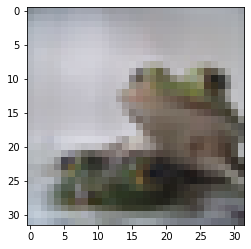

In [37]:
testindex = 50
img = x_test[testindex]
print("Correct label =",label_name(y_test_numerical[testindex]))
plt.imshow(img)
img = img.reshape((1,) + img.shape)
print("Prediction:",vae.encoder.predict(img))
print("Prediction:",vae.decoder.predict(vae.encoder.predict(img)))
#print(vae.decoder.predict(vae.encoder.predict(img)).type
print(vae.encoder.predict)
#plt.imshow(vae.decoder.predict(vae.encoder.predict(img)))


frog


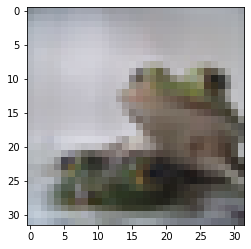

In [15]:
import matplotlib.pyplot as plt
testindex = 50
img = x_test[testindex]
plt.imshow(img)
print(label_name(y_test_numerical[testindex]))